# Capstone 1 Milestone Report
## ADNI Alzheimer's Disease Data

#### Introduction

This project and dataset were chosen because the potential solutions to be discovered from this dataset could provide extremely important solutions for medical providers, caregivers, and especially patients regarding Alzheimer's Disease (AD). AD is the most expensive disease in America according to the [Alzheimer’s Association](alz.org). This dataset was chosen because it contains information collected from the same patients over multiple exams that were conducted years apart in many cases. This provides the opportunity to explore changes over time as well as searching for baseline biomarkers that might be able to predict AD in patients that do not yet have the disease.

#### The dataset
- Datasource [ADNI website](http://adni.loni.usc.edu/data-samples/access-data/)
- Documentation 
> Data used in the preparation of this article were obtained from the Alzheimer’s Disease
Neuroimaging Initiative (ADNI) database (adni.loni.usc.edu). The ADNI was launched in
2003 as a public-private partnership, led by Principal Investigator Michael W. Weiner,
MD. The primary goal of ADNI has been to test whether serial magnetic resonance imaging
(MRI), positron emission tomography (PET), other biological markers, and clinical and
neuropsychological assessment can be combined to measure the progression of mild
cognitive impairment (MCI) and early Alzheimer’s disease (AD). For up-to-date information,
see [www.adni-info.org](www.adni-info.org).

In [1]:
# import packages
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import wrangle_adni to import/wrangle the data
from adnidatawrangling import wrangle_adni

# import custom modules eda, sda for exploratory/statistical data analysis
import eda, sda

# set seaborn defaults
sns.set()

#### Data Wrangling

The data were included in one table, ADNIMERGE.csv, which was imported, wrangled, and cleaned primarily through the use of the python package pandas. This process involved exploring the structure of the data using methods and attributes of dataframes such as `.head()`, `.info`, and `.shape` among other. Additional methods such as `.value_counts()` were used to further summarize and explore the data.

Datatypes were set using `.astype()`, `pd.to_datetime`, and `pd.Categorical`. A loop was created to sift through the data using `.isnull().sum()` and `isnull().mean()` to describe missing values. Some biomarkers were removed from the data completely due to too much missing data. For the remaining dataset, every row was dropped that included any missing values using `.dropna(how='any')`.The index was set and sorted using the date column along with the patient ID. 

The results were then filtered to only include patients for which there were at least two exams performed. To accomplish this, the `.groupby()` method was employed, chained with `.count()` to store the number of visits for each patient ID. This list was then used to filter the dataset to only those patients with multiple exams.

The data were then divided into a few meaningful dataframes including all of the clinical data, all of the scan data, and one dataframe that only included the last exam date for each patient. This last dataframe I labeled `final_exam` was very useful, as the data contained columns for the baseline values for each biomarker. Therefore, the `final_exam` dataframe contained the data from the first and the last examdate for each patient.

A quick analysis for outliers was performed using `.plot(kind='box')` method of dataframes. This analysis revealed that there were no outstanding values that appeared to be invalid. Through these processes, a complete dataset including only patients with multiple visits was obtained, cleaned, and prepared for analysis. To make those steps replicable and to save time for future analysis, a .py script was created containing functions and steps to reproduce the dataframes.

In [2]:
# import data, clean, and extract data
adni_comp, clin_data, scan_data = wrangle_adni()

In [3]:
# extract final exam data: only the last exam for each patient
final_exam = eda.get_final_exam(adni_comp)

#### Exploratory Data Analysis (Data Story Unit)

The next steps were part of the Data Story Unit, but it was more of an exploratory data analysis. The data were explored to see if there was an equal (or close to it) representation of males/females in the data. A quick plot showed that both genders were represented well in the study.

In [4]:
# subset only the baseline data from the complete dataset

adni_bl, clin_bl, scan_bl = eda.get_bl_data(adni_comp, clin_data, scan_data)

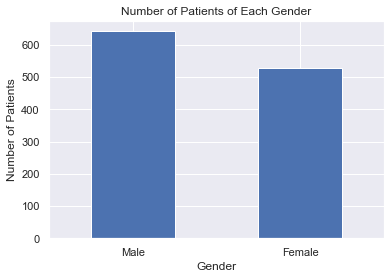

In [5]:
# plot gender counts

_ = eda.plot_gender_counts(adni_bl)

The data were then explored to see how many of each diagnosis was in the data.

The first figure shows the number of baseline diagnoses. Of the 1170 patients, 329 had a baseline diagnosis of cognitively normal (CN), 48 were diagnosed as subjective memory complaint (SMC), 224 were diagnosed as early mild cognitive impairment (EMCI), 395 were late mild cognitive impairment (LMCI), and 174 were already diagnosed with Alzheimer's disease (AD) by their first visit. 

It was during this analysis that it was discovered the initial baseline visit had five categories for diagnosis: cognitively normal (CN), subjective memory complaint (SMC), early mild cognitive impairment (EMCI), late mild cognitive impairment (LMCI), and Alzheimer's Disease (AD). The subsequent visits, however, only used three diagnoses of CN, MCI, or AD. For the purpose of this analysis, CN and MCI were combined into CN per definitions of SMC obtained from relevant sources. EMCI and LMCI were combined into MCI for comparisons.

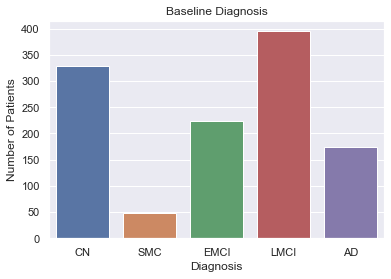

In [6]:
# plot baseline diagnosis

_ = eda.plot_bl_diag(adni_bl)

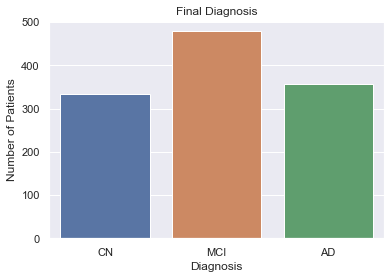

In [7]:
# plot the final diagnosis counts

_ = eda.plot_final_diag(adni_comp)

Once the baseline diagnoses had been mapped to match the final diagnoses, a plot was created to visualize how the diagnoses change during the course of the study. This plot included three bars for the baseline diagnosis, and the colors of the three bars indicate the diagnosis for those patients at the end of the study.

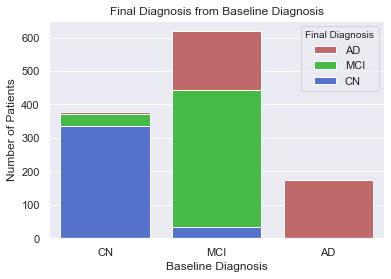

In [8]:
# plot the change in diagnosis paired with baseline diagnosis

_ = eda.plot_dx_change(final_exam)

This plot revealed that most CN patients remained that way for the duration of the study, though a few did progress to MCI and AD. Most of the MCI patients remained that way, though there were many that progressed to AD. 

#### Exploratory Data Analysis Questions

The next step was to frame the big questions.
1. Which biomarkers tend to change when the diagnosis changes and could possibly be used to identify patients that are progressing towards AD?
2. Which biomarkers could possibly predict AD from an initial measurement only (at the baseline exam)?

To begin answering these questions, some initial plots were created to check for biomarkers that would be of interest for statistical testing. The initial idea was that the biggest change in biomarkers would be between the initial visit and the final visit. The plot above also indicated that in general, most patients did not improve in diagnosis (with few exceptions). For these reasons, the `final_exam` dataset was the dataframe used primarily for this analysis. 

New columns were added to the `final_exam` dataframe with the suffix 'delta' to calculate the change in each biomarker for every patient between their baseline exam and their final exam. These 'delta' columns would be the basis to begin identifying the candidate biomarkers to answer the first question above. The data also had to be divided into 'diagnosis groups' based on the change in diagnosis during the study. The fuction used to do this also setup labels for these groups and calculated the best size bins to use for the histogram based on accepted standards.

In [9]:
# calculate the change in variables over the course of the study
eda.calc_deltas(final_exam)

# setup the parameters needed for plot_hist and plot_dist functions
dist_groups, labels, dist_bins = eda.setup_dist_plots(final_exam)

1. Which biomarkers change as diagnosis changes?

Plots that included both histograms and distribution plots were created for each biomarker to search for the best candidates for further analysis. These plots would have distributions that overlapped the least by diagnosis group. Pretty much all of the biomarkers displayed some change when patients changed diagnosis. This was not a surprising result, given what the biomarkers measure and the obvious reason that these biomarkers are used by medical professionals to help evaluate patients with regards to AD.

A few of the plots are displayed here to show the contrast between a biomarker with a large change with diagnosis change and one with a lower amount of change with change in diagnosis.

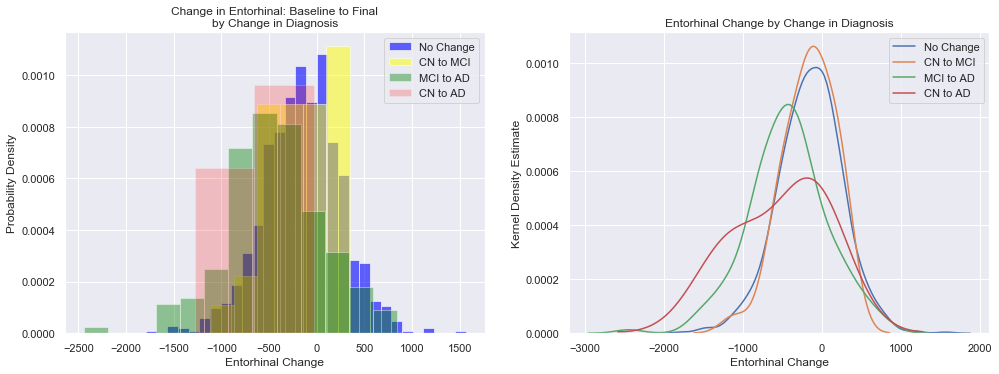

In [10]:
# plot the Entorhinal_delta scores
_ = eda.plot_histdist('Entorhinal_delta', dist_groups, labels, dist_bins)

In the plot for Entorhinal above, you can see that the red distribution (CN to AD) does move to the left some. The peaks of each curve on the distribution plot on the right, however, do not move very much given how wide the curves are. This means that while there appears to be a change in the biomarker with different diagnosis groups, there is not a clear separation of the distributions. It does appear, though, that the blue line (no change) goes to nearly 0 by about -1400 change, while both groups that progressed to AD continue beyond -1600 change.

This should be compared in contrast to the ADAS13 change plotted below. This plot clearly shows the peaks of the distribution moving to the right with each diagnosis group (though both that progress to AD have similar peaks). This shows that the average change increased as the diagnosis group changed. It is also clear that the red and green groups that both progress to AD have ADAS13 changes much higher than the blue and orange curves (patients that didn't progress to AD).

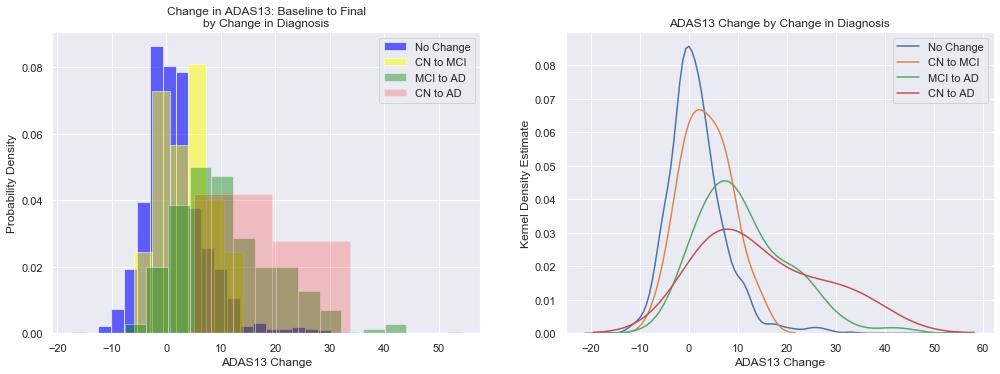

In [11]:
# plot the ADAS13_delta scores
_ = eda.plot_histdist('ADAS13_delta', dist_groups, labels, dist_bins)

Using these plots, the candidates that stood out for warranting further statistical testing were CDRSB, ADAS11, ADAS13, MMSE, Hippocampus, Ventricles, and MidTemp. The RAVLT_immediate, WholeBrain, and Entorhinal plots hinted at a change but did not show the extend of the trend observed in the other biomarkers.

2. Which baseline biomarkers might be able to predict a final diagnosis of Alzheimer's Disease?

A few parameters needed to be defined to create the baseline distributions for each biomarker separated by final diagnosis. A function was created to divide the data and setup these parameters.

After this a function was created to plot one to two baseline variables, separating the plots by gender to see if there appeared to be a difference between them. The plots were generated for all variables, but four biomarkers in particular stood out as having a good potential to predict AD from an initial exam alone. Those biomarkers were ADAS11, ADAS13, Hippocampus, and MidTemp, and the plots are displayed below.

In [12]:
# setup the indicators for histograms comparing males and females
# this divides up the data into groups based on final diagnosis and gender
setup_indicators = eda.setup_indicators(final_exam)

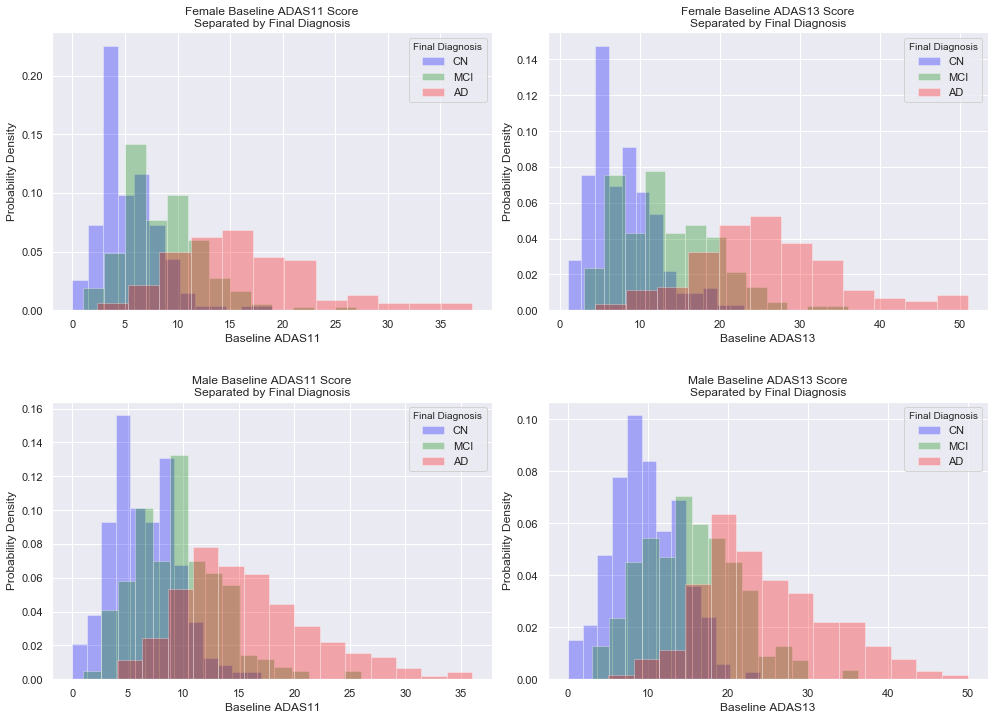

In [13]:
# plot baseline ADAS11 and ADAS13 scores separated by gender and final diagnosis
_ = eda.plot_indicators(column1='ADAS11_bl', column2='ADAS13_bl', si=setup_indicators)

Functions were also created to provide some exploratory summary information on these datasets. These functions were used to create initial estimates of threshold values for determining which patients were more at risk for developing AD. 

In [14]:
# summarize female ADAS11 baseline threshold
eda.summarize_bl_thresholds(final_exam, column='ADAS11_bl', gender='Female', threshold=16)

25 of 33 patients had baseline ADAS11_bl values exceeding the threshold of 16 
and ended with AD.

75.76% of patients that didn't have AD yet but had ADAS11_bl 
exceeding threshold value of 16 ended with AD.


In [15]:
# summarize male ADAS11 baseline threshold
eda.summarize_bl_thresholds(final_exam, column='ADAS11_bl', gender='Male', threshold=17)

18 of 31 patients had baseline ADAS11_bl values exceeding the threshold of 17 
and ended with AD.

58.06% of patients that didn't have AD yet but had ADAS11_bl 
exceeding threshold value of 17 ended with AD.


The summary info above provided an intial estimate of threshold values for ADAS11 and ADAS13. More appropriate values were later determined using statistical methods, and it was determined that lower thresholds could be used to identify patients with higher risk of AD.

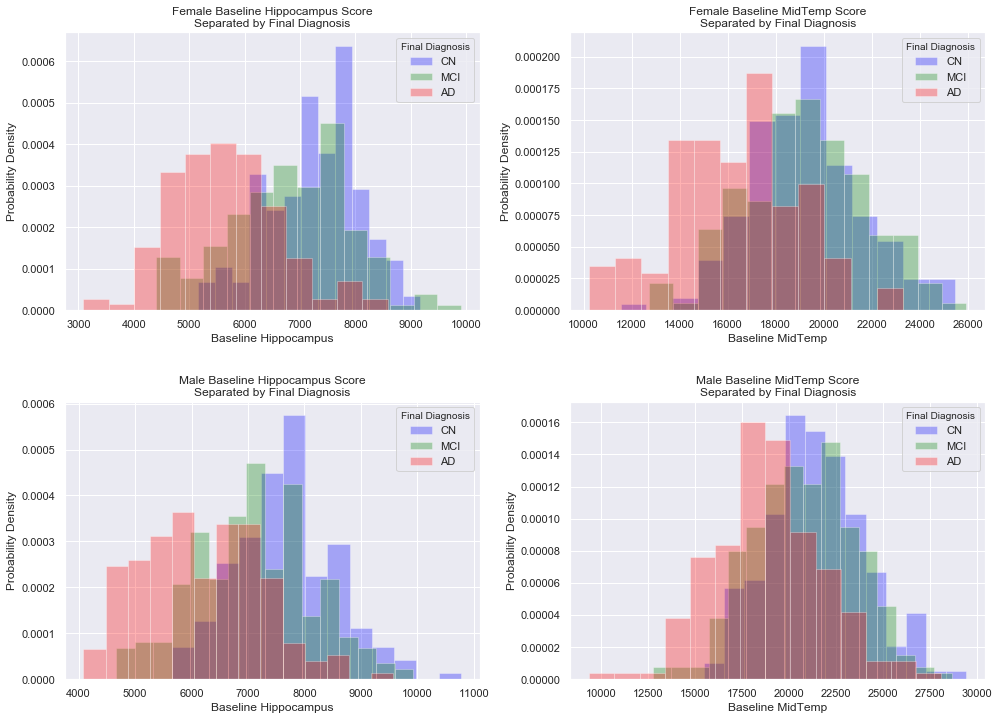

In [16]:
# plot baseline Hippocampus and MidTemp scores separated by gender and final diagnosis
_ = eda.plot_indicators(column1='Hippocampus_bl', column2='MidTemp_bl', si=setup_indicators)

In [17]:
# summarize female MidTemp baseline threshold
eda.summarize_bl_thresholds(final_exam, column='MidTemp_bl', gender='Female', threshold=14500)

12 of 17 patients had baseline MidTemp_bl values exceeding the threshold of 14500 
and ended with AD.

70.59% of patients that didn't have AD yet but had MidTemp_bl 
exceeding threshold value of 14500 ended with AD.


The plots above for Hippocampus and MidTemp suggested they could be used to help ID patients at risk for AD. The summary info provided by the function above could provide some basic quick info on the data for the chosen threshold, but this threshold was chosen by trying to see where the blue/green plots separated from the red plot. 

More than anything, these exploratory analyses provided a list of biomarkers that should be statistically tested for meaningful threshold values. That was the next phase of this project.

## Statistical Data Analysis

This section of the project sought to use statistical methods to provide answers to the two primary questions of interest for this study: which biomarkers show a change as diagnosis changes, and which biomarkers have threshold values that could be used at an initial exam to identify the most at risk individuals for developing AD.

### Question 1: Which biomarkers would show a change associated with progression to Alzheimer's Disease?

Subquestion: Is there a difference beteween males and females for mean biomarker change?
- Null Hypothesis 1: There is no difference in how much biomarkers changed in this study between males and females.
- Alternative Hypothesis: For some or all of the biomarkers, there will be a significant difference between males/females in mean biomarker change during the study.
- Statistical test: permutation test to see if the observed difference is greater than a difference observed by random chance.


To be able to answer the question about biomarker changes indicating a change in diagnosis, it had to be determined first whether or not the data should be separated by gender. Permutation tests were performed using a custom function to create many random distributions that mixed the data to create an expected mean if the null hypothesis were true (that is if males and females came from the same distribution for the amount of change in a biomarker).

This test was performed for all biomarkers since every biomarker showed at least some change among the diagnosis groups. Biomarkers that displayed no significant difference between genders were CDRSB_delta, MMSE_delta, RAVLT_delta, Hippocampus_delta, WholeBrain_delta, and Entorhinal_delta. The tests that showed there was a significant difference between males/females were ADAS11_delta, ADAS13_delta (p-value was slightly above 0.05), Ventricles_delta, and MidTemp_delta. The ADAS13_delta test was considered 'significant enough' for two reasons: the p-value was above but very close to 0.05 and the ADAS11_delta data was split so there was enough cause to split the ADAS13_delta data.

Examples of a result with no significant difference (CDRSB_delta) and a test with a significant difference (Ventricles_delta) are show below as examples.

In [18]:
# reset plotting size
plt.rcParams["figure.figsize"] = (6.0, 4.0)

Distribution Test for Males/Females
Variable:  CDRSB_delta
If p < 0.05, then split the data by gender
p-value:  0.4527


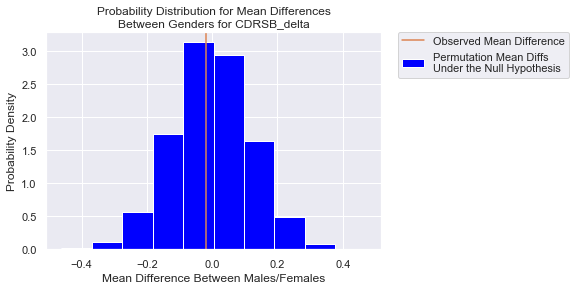

In [19]:
# function parameters are: dataframe, biomarker, number of permutations
sda.test_gender_effect(final_exam, 'CDRSB_delta', 10000)

The mean difference under the null hypothesis is 0 for all biomarkers. This is because the null hypothesis expects 0 difference between males and females for their 'delta' values. The observed mean difference for CDRSB_delta between males/females was very close to 0 and yielded a p-value of about 0.44, meaning there was about a 44% chance that the observed difference was due to random chance. Therefore this biomarker (and the others with higher p values) were not split by gender. Other tests did display a difference, and an example is shown below.

Distribution Test for Males/Females
Variable:  Ventricles_delta
If p < 0.05, then split the data by gender
p-value:  0.0003


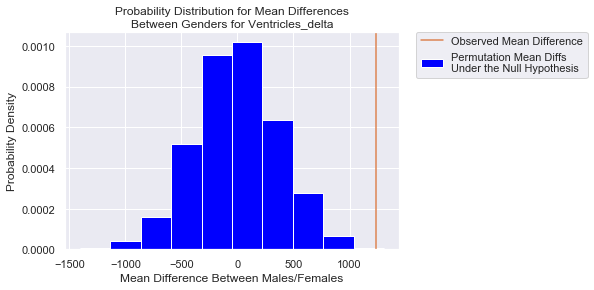

In [20]:
# function parameters are: dataframe, biomarker, number of permutations
sda.test_gender_effect(final_exam, 'Ventricles_delta', 10000)

This plot and associated p-value show that the observed difference between males and females was outside the 95% confidence interval for a one-tailed test or even a two-tailed test. This means that in this case, there was about a 0.05% probability that the observed mean difference was due to random chance. For the biomarkers that produced similar results, the data were split into groups based on gender and analyzed separately.

### Question 1: The Tests for a Correlation with Diagnosis Change

This question could be answered in yes/no fashion, but this would not provide the most useful results. Ideally the methods used here could provide some level of confidence on the ability to predict a diagnosis change. It would also reveal the risk of producing false positives or identifying individuals as likely to develop AD or 'at risk' patients that did not develop AD during the course of the study.

- Null Hypothesis: There is no threshold value that can predict progression to AD with a high percentage and keep a low percentage of 'false positive' results where patients would be notified of higher risk that don't receive an AD diagnosis.
- Alternative Hypothesis: There is a threshold value for change in a biomarker that when exceeded, likely means a change in diagnosis far more often than not. 
    - This would be a level where the detection rate is high enough and the false positive rate is low enough to notify every patient that exceeds this threshold that they have a high risk of AD.

To detect and calculate these confidence levels, a bootstrap analysis was performed to find the 95% confidence interval around the mean change for patients that did not show a change in diagnosis. Breaking that statement down, the all patients that did not change diagnosis during the study were used as the control group. The idea is to predict a change in diagnosis, so the group representing the distribution for the null hypothesis should show no change in diagnosis. 

The 95% confidence interval around this mean was calculated for each test. This allows the comparison of all of the individual data points to this confidence interval. Each diagnosis group that experienced a change was compared to the estimated no change threshold values. The percentage of patients that exceeded this threshold was calculate as the 'detection rate' for this threshold value. 

In addition to comparing the diagnosis groups based on change in diagnosis, percentages were calculated for each final diagnosis (CN, MCI, AD) to see what percentage of patients that ended with a specific diagnosis experienced that level of change using a custom function. This might detect patients that started with AD, showed a change in a biomarker, but were included in the 'no change' group because their initial diagnosis was the same as their final diagnosis. Example results are shown below.

In [21]:
# divide data into groups based on change in diagnosis
# groups were identified in the first part of this analysis that need to be split by gender
# those are ADAS11, ADAS13, Ventricles, and MidTemp (divided by gender)

fe_males, fe_females = sda.divide_genders(final_exam)
no_change, cn_mci, mci_ad, cn_ad = sda.get_deltadx_groups(final_exam)
m_no_change, m_cn_mci, m_mci_ad, m_cn_ad = sda.get_deltadx_groups(fe_males)
f_no_change, f_cn_mci, f_mci_ad, f_cn_ad = sda.get_deltadx_groups(fe_females)

In [25]:
# setup dataframe to store the results for summarizing
# because the changes df was populated by running all of the eval_bs functions,
#    the changes df is recreated using data produced during analysis

#cols = ['biomarker', 'thresh', 'end_cn', 'no_prog', 'prog_CN_MCI', 'prog_MCI_AD', 'prog_CN_AD']
cols = ['biomarker', 'thresh', 'pct', 'group']
changes = pd.DataFrame(columns=cols)

95% Confidence Interval:  -1.012008733624454  to  -0.6495633187772926


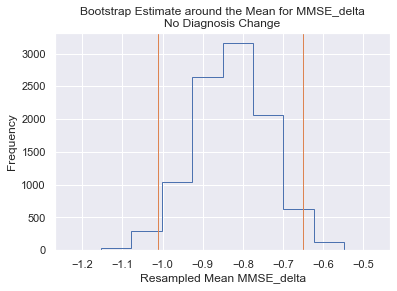

In [22]:
# calculate the confidence interval for patients with no change in diagnosis
mmse_conf = sda.bs(no_change, 'MMSE_delta', 10000)

In [27]:
c = sda.eval_bs(final_exam, 'MMSE_delta', mmse_conf, changes, cols)

Threshold:  -1.012008733624454
Percent exceeding threshold that ended CN:  14.89 %
Percent exceeding threshold that ended MCI:  28.0 %
Percent exceeding threshold that ended AD:  57.11 %
Percent with no diagnosis change exceeding threshold:  30.79 %
Percent progressing CN to MCI exceeding threshold:  27.03 %
Percent Progressing MCI to AD exceeding threshold:  83.52 %
Percent Progressing CN to AD exceeding threshold:  100.0 %


The figure above shows the bootstrap distribution of the mean for change in MMSE along with its 95% confidence interval. The proceeding function evaluates the biomarker to choose the correct threshold value based on whether or not the biomarker increases or decreases with progression to AD. The detection rate and false positives for the threshold values are also displayed and were determined from the 95% confidence interval values that printed above the graph.

For MMSE_delta, the threshold is about -1.02 signifying a decrease in MMSE. Assume for a minute that every patient that displayed an MMSE decrease of 1.02 or more was notified that they are likely to receive an AD diagnosis. Starting at the bottom of the printout above, this would notify 100% of the patients that progressed from CN to AD during the study. About 84% of patients that went from MCI to AC would have been notified as well. about 27% of patients that progressed from CN to MCI would be notified as well, and this would be considered a 'false positive' rate. It could be noted, though that this group might eventually progress to AD given more time.

Proceeding upward in the printout above shows the percentage of patients that ended in a specific diagnosis that exceeded the threshold, again giving an indicator of power to detect AD and false positive rate. Only about 57% of patients that exceeded the threshold ended the study with an AD diagnosis. Therefore 43% of patients that exceeded the threshold would have been notified they were at risk but not yet developed AD. The 28% that ended MCI is not that concerning, though, as they may still be at a high risk of developing AD. The real false positive rate is the group that ended CN which is around 15%. 

To evaluate if this is a good biomarker to detect a change in diagnosis, the question is, is it worth notifying the 15% of patients that don't progress towards AD that may alarm them to aid the 57-85% of patients that have more advanced diagnoses? Looking at those that experienced a change in diagnosis shows that the real power in this threshold, however, is in detecting those that have experienced a change, rather than simply using a change in this value to predict a final diagnosis.

The test below shows an example of a biomarker that shows very little power to detect a change in diagnosis as it changes. This is evident by analyzing the percent detection rate and false positive rates printed below the figure.

95% Confidence Interval:  -176.41430131004367  to  -122.78408842794761


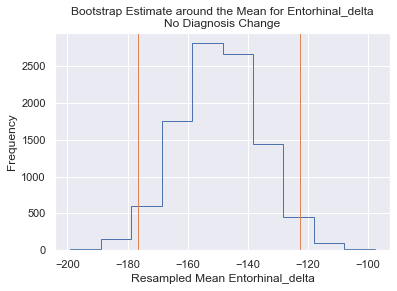

In [29]:
# calculate the confidence interval for patients with no change in diagnosis
ent_conf = sda.bs(no_change, 'Entorhinal_delta', 10000)

In [30]:
c = sda.eval_bs(final_exam, 'Entorhinal_delta', ent_conf, changes, cols)

Threshold:  -176.41430131004367
Percent exceeding threshold that ended CN:  28.5 %
Percent exceeding threshold that ended MCI:  33.85 %
Percent exceeding threshold that ended AD:  37.65 %
Percent with no diagnosis change exceeding threshold:  45.96 %
Percent progressing CN to MCI exceeding threshold:  40.54 %
Percent Progressing MCI to AD exceeding threshold:  73.3 %
Percent Progressing CN to AD exceeding threshold:  40.0 %


The values above starting at the bottom indicate that only 40% of patients that progressed from CN to AD actually exceeded the threshold value that is supposed to detect progression to AD. This is a very low rate. It would have notified about 73% of patients that progressed from MCI to AD, possibly suggesting that these changes occur much later than some of the other biomarkers.

The biggest issue with this threshold is the three percentages at the top. The are very nearly divided evenly (which would be 33%). This means that if you informed everyone that exceeded this threshold during the study, nearly 2/3 of the patients would not have developed AD yet.

When this type of result occurs, it doesn't mean the biomarker is useless to detect progression to AD, but it means the calculated threshold for that biomarker alone is not enough to go telling patients they have AD or are even at higher risk for developing AD. Instead, this type of biomarker should only be used in conjunction with other measures when making the determination to consult with a patient about their individual risk of developing AD.

In [31]:
# rebuild the changes df, that was constructed from all of the 'eval_bs' functions
changes = sda.rebuild_changes_df()

## Question 1 Results Summary: 
#### Summary of Changes in Clinical Biomarkers

The plot below displays the detection rates for changes in diagnosis for patients that exceeded the calculated thresholds above. Every clinical biomarker showed a 100% detection rate for patients that progressed from CN to AD. The clincial exams also had a high detection rate for patients that progressed from MCI to AD, ranging from about 74% for RAVLT_delta to the highest for CDSRB_delta of about 95%. These are very good detection rates for the two groups that progressed to AD.

Patients that progressed from CN to MCI did not exceed the calculated threshold values as often, with detection rates mostly between about 45% to just over 60%. MMSE_delta had the lowest detection rate, which was around 27%.

The false positive rates are displayed below the Detection rates. Because the primary goal of this analysis was to detect a change in diagnosis, the diagnosis group with no change is displayed as a false positive, however, the better indicator of false positives is probably the group 'Ended CN'. Some of the patients that did not experience a change in diagnosis already had AD or were diagnosed with MCI. The deliberate choice to include those patients in the no change group undoubtedly increased the values calculated for the threshold. This would decrease the detection rates. Given that every biomarker except one had detection rates for chang to AD of 80% or better, these thresholds have a pretty good detection power that would be useful for medical professionals.

Only one biomarker had a false positive rate for patients that ended CN above 20% (RAVLT_delta), and it was only about 25%. that If doctors warned patients that showed changes in a single biomarker above the thresholds calculated, less than 25% of those patients would not have progressed in diagnosis.

One biomarker stands out as the best for detecting a change to AD, and that was the CDRSB_delta. The threshold for this biomarker had a very low false positive rate of just 4%, while detecting change to AD at greater than 95%. The other biomarkers had more power to detect a change from CN to MCI with the exception of MMSE_delta.

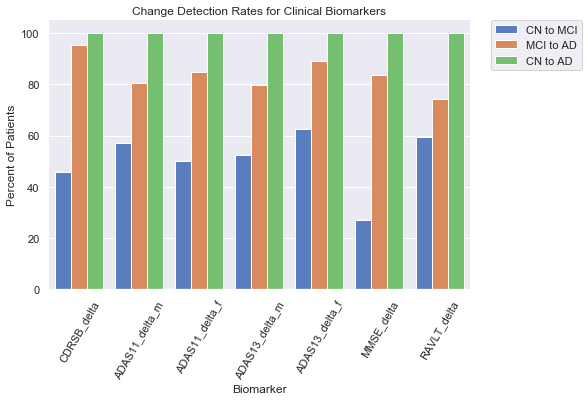

In [34]:
sda.summarize_clin_changes(changes)

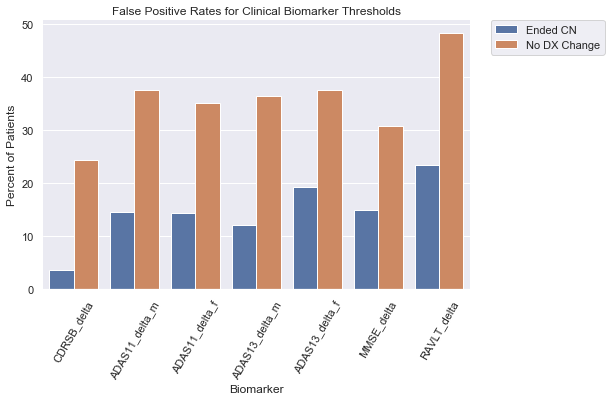

In [35]:
# false positive rates for the clinical biomarkers
sda.summarize_clin_fps(changes)

## Question 1 Results Summary:
#### Summary of Changes in Scan Biomarkers

Overall, the scan thresholds had less detection power than the clinical exams. Only the change in ventricles for males from CN to AD had a detection rate of 100%. Most of the detection rates were less than 80%. Entorhinal_delta overall appeard to have the worst detection rate. 

This doesn't mean that these biomarkers can't be used to detect a change, but the advice would be to use a combination of biomarkers. The methods used in this analysis didn't produce the best combination of biomarkers, and further analysis will be performed to answer this question.

The false positive rate for patients that ended with a CN diagnosis mostly ranged from about 20-30%, though the rate for change in ventricles for males again performed the best with a false positive rate under 20%. 

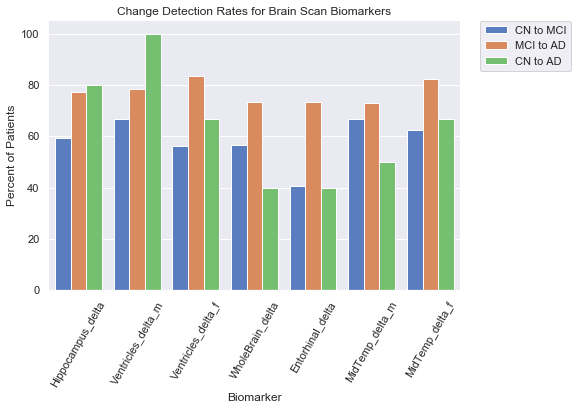

In [36]:
sda.summarize_scan_changes(changes)

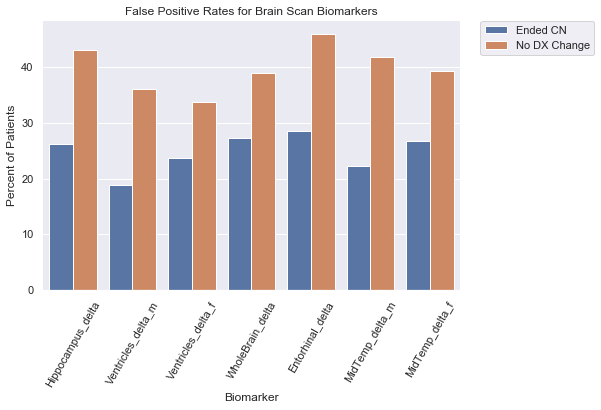

In [37]:
sda.summarize_scan_fps(changes)

### Question 2: Which Baseline Biomarkers Can Predict Alzheimer's Disease?
#### Part 1: Test for Gender Effect

- The gender effect will again be tested to ascertain when the data need to be split by gender
    - Null Hypothesis: Gender has no effect, males/females will have the same distribution of baseline values
    - Alternative Hypothesis: At least some biomarkers will need to be split by genders because of a significant difference between males/females
    - Statistical test: permutations test, with $\alpha$=0.05

### Question 2: Which Baseline Biomarkers Can Predict Alzheimer's Disease?
#### Part 2: This is the holy grail question. Which biomarkers could predict AD at the first exam?

- Once it was determined whether or not to split the data, the test between AD/non AD was performed.

- Null Hypothesis: There is no difference between the distribution of AD patients and non AD patients for the biomarkers
- Alternative Hypothesis: The distributions in baseline measurements are different between patients that ended AD and those that didn't for at least some biomarkers

- Statistical methods:
    - First, permutation tests were performed to determine if there was indeed a significant difference between the AD/non AD group
        - All groups showed a difference and were examined for threshold values
    - Fro threshold calculations, the goal was again not to obtain a p-value, but instead to identify threshold values that will detect a high percentage of AD patients, while producing a low percentage of false positive results
    - Bootstrap distributions were created for the extreme values of each distribution that could possibly overlap rather than for the mean of either the AD or non AD distributions 
        - The benchmarks set were the 75% detection rate and the 25% false positive rate
        - These were seen as acceptable levels of uncertainty to begin discussions with patients
        - To evaluate these thresholds, a function was created to determine the false positive rate at 75% detection and the detection rate at 25% false positive

#### Question 2.1 Test for Gender Effect

The same statistical test was used here to test for gender effect as before for the change in biomarkers section. The data were divided into two groups, those with a final diagnosis of AD and those that didn't received a final diagnosis of AD. Every single baseline biomarker had a statistical difference between males/females except CDRSB_bl, but the variance was different enough between the two groups that this biomarker was also split by gender.  Two examples of the tests are displayed below.

Distribution Test for Males/Females
Variable:  ADAS11_bl
If p < 0.05, then split the data by gender
p-value:  0.0026


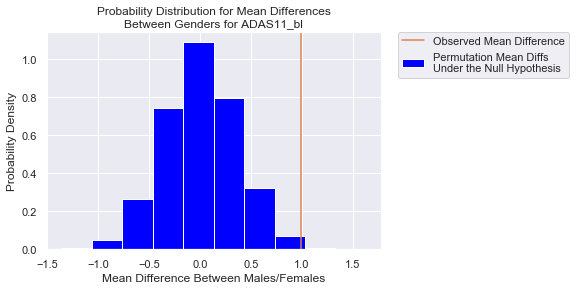

In [48]:
sda.test_gender_effect(final_exam, 'ADAS11_bl', 10000)

Distribution Test for Males/Females
Variable:  MidTemp_bl
If p < 0.05, then split the data by gender
p-value:  0.0


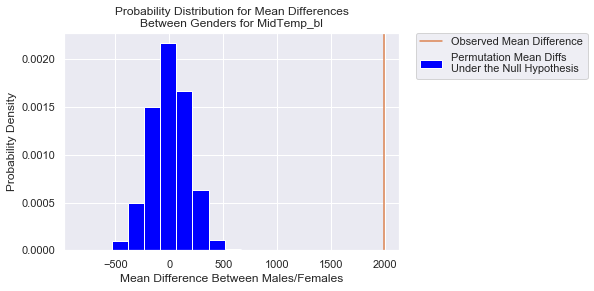

In [47]:
sda.test_gender_effect(final_exam, 'MidTemp_bl', 10000)

#### Question 2.2 Which Baseline Biomarkers Can Predict a Final Diagnosis of Alzheimer's?

Permutation tests for all biomarkers showed a significant difference in baseline values, and two examples are displayed below. The biomarkers were then analyzed for threshold values.

Distribution Test for AD/Non AD
Variable:  ADAS11_bl
If p < 0.05, then patients that ended AD had a different distribution for  ADAS11_bl
p-value:  0.0


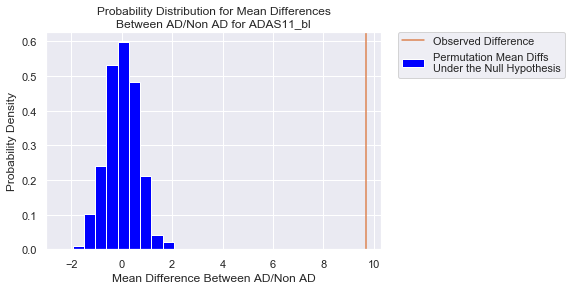

In [49]:
sda.bl_perm_test(final_exam, 'ADAS11_bl', 'Male', 1000)

Distribution Test for AD/Non AD
Variable:  Hippocampus_bl
If p < 0.05, then patients that ended AD had a different distribution for  Hippocampus_bl
p-value:  0.0


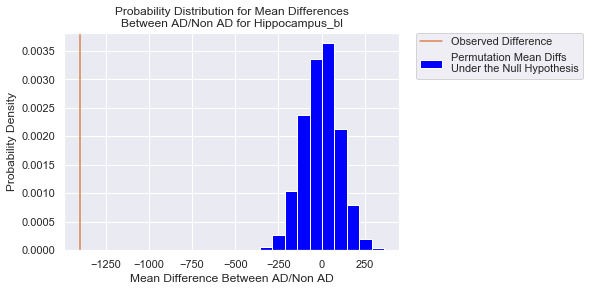

In [50]:
sda.bl_perm_test(final_exam, 'Hippocampus_bl', 'Female', 1000)

#### Some Assumptions for interpretation of baseline thresholds
- A final diagnosis would occur within the time limit of a patient's first to last visit
    - The overall duration of the study was about 11 years, with most patients not having 11 years worth of data
- We are assuming also that this sample of patients is representative of the general population
    - This assumption is important for applying these thresholds to other potential patients
    - Further exploration of these calculated thresholds should be performed to test their consistency and applicability to other samples of patients

#### Question 2.2 Baseline Threshold Calculations

Two functions were created to calculate the threshold values. The first calculated four different bootstrap distributions that represented the extremes of the AD group and non AD group. These distributions were then plotted, and the two distributions that could represent threshold values were returned (75% detection rate and 25% false positive rate). These were chosen as 75% was considered a good detection rate, while the 25% false positive rate was also calculated to see if it was possible to increase the detection rate above 75%. The 25% false positive rate was considered an acceptable level of false positives for alerting patients that they might be at higher risk of AD.

The second function was used to return the false positive rate at 75% detection and the detection rate at 25% false positive rate. The best biomarkers for predicting AD would have high detection rates and low false positive rates.

There were three general patterns that emerged with these analyses. Bad predictors, decent predictors, and good predictors. Examples of each type of pattern are displayed below.

#### The bad predictors

The baseline biomarkers that were not good at predicting AD have a rainbow color pattern, that is the colors go in order blue, green, red, yellow (or the opposite order). This pattern means that there is a lot of overlap in the distributions of the AD and non AD groups. This can occur even when the means of the distributions are statistically different, if the distributions still have much overlap. The first test shown below for the ventricles from females is one such test. The detection rate for the threshold value with a 25% false positive rate (patients that exceeded the threshold but didn't receive an AD diagnosis) was only about 40%, while the false positive rate at 75% detection was over 50%.

25% false positive threshold value:  37946.07
75% detection threshold value:  24400.9529


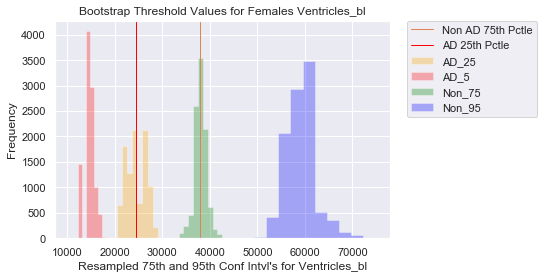

In [51]:
bs_non_75, bs_ad_25 = sda.bs_percentile(final_exam, 'Ventricles_bl', 10000, 'females')

In [52]:
sda.get_pctles(bs_non_75, bs_ad_25, final_exam, 'Ventricles_bl', 'females', increase=True)

The detection rate for AD with 25% false positive is 40.15 %
The false positive rate for 75% AD detection is 52.57 %


#### The ok predictors

The baseline biomarkers that had a decent but not great performance had the red line (25% false positive) and orange line (75% detection) basically on top of each other. By definition, these biomarkers showed a 75% detection rate and 25% false positive rate. An example is displayed below.

25% false positive threshold value:  3152.1525
75% detection threshold value:  3144.4034


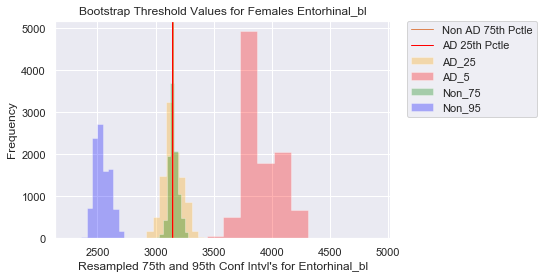

In [53]:
bs_non_75, bs_ad_25 = sda.bs_percentile(final_exam, 'Entorhinal_bl', 10000, 'females')

In [54]:
sda.get_pctles(bs_non_75, bs_ad_25, final_exam, 'Entorhinal_bl', 'females', increase=False)

The detection rate for AD with 25% false positive is 75.77 %
The false positive rate for 75% AD detection is 24.85 %


#### The Good Predictors

Good predictors were those where the distributions between AD and non AD were separated the most. The percentile plots showed the red and green distributions close to each other and the blue and yellow close together. The red and orange lines were also very spread apart. These would tend to have high detection rates and low false positive rates. An example is shows below.

25% false positive threshold value:  13.795296999999886
75% detection threshold value:  19.99439200000004


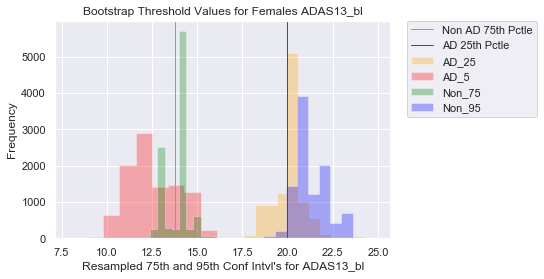

In [55]:
bs_non_75, bs_ad_25 = sda.bs_percentile(final_exam, 'ADAS13_bl', 10000, 'females')

In [56]:
sda.get_pctles(bs_non_75, bs_ad_25, final_exam, 'ADAS13_bl', 'females', increase=True)

The detection rate for AD with 25% false positive is 92.95 %
The false positive rate for 75% AD detection is 7.81 %
